# 7. Predictive Modeling: Final Biomass Prediction

This notebook uses the foundational data from our analysis to address a new predictive question for the CSCI 5260 AI project: **Can we predict a plant's final biomass using only data from the first 14 days of growth?**

## Workflow
1.  **Feature Engineering:** Create summary statistics for each plant using data from the first 14 days.
2.  **Target Definition:** Define the target variable as the `Final_Area` (raw pixel value) from the last day of the experiment.
3.  **Model Training:** Train three regression models: Linear Regression, Random Forest, and XGBoost.
4.  **Evaluation:** Compare the models using R-squared and Mean Absolute Error, and visualize the performance of the best model.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import sys
import os

# Add parent directory to path to import custom functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_processing import load_data, preprocess_data

In [22]:
# Load the full, original dataset
FEATURES_PATH = '../data/5.25.2024_CBI.0010_York_Poplar_RGB.side_features.csv'
BARCODE_PATH = '../data/barcodes--5.25.2024_CBI.0010_York_Poplar.csv'
data_df, barcode_df = load_data(FEATURES_PATH, BARCODE_PATH)
merged_df = preprocess_data(data_df, barcode_df)
print("Original data loaded successfully.")

Original data loaded successfully.


## Feature Engineering
We will create a single row for each plant, summarizing its growth and color metrics over the first 14 days.

--- Running analysis for first 14 days ---


C:\Users\katie\AppData\Local\Temp\ipykernel_26708\3833163486.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_features = early_df.groupby('Plant Info').apply(calculate_all_slopes)


  R-squared for 14 days: 0.284

--- Running analysis for first 21 days ---


C:\Users\katie\AppData\Local\Temp\ipykernel_26708\3833163486.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_features = early_df.groupby('Plant Info').apply(calculate_all_slopes)


  R-squared for 21 days: 0.611

--- Running analysis for first 28 days ---


C:\Users\katie\AppData\Local\Temp\ipykernel_26708\3833163486.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_features = early_df.groupby('Plant Info').apply(calculate_all_slopes)


  R-squared for 28 days: 0.796

--- Running analysis for first 35 days ---


C:\Users\katie\AppData\Local\Temp\ipykernel_26708\3833163486.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_features = early_df.groupby('Plant Info').apply(calculate_all_slopes)


  R-squared for 35 days: 0.832



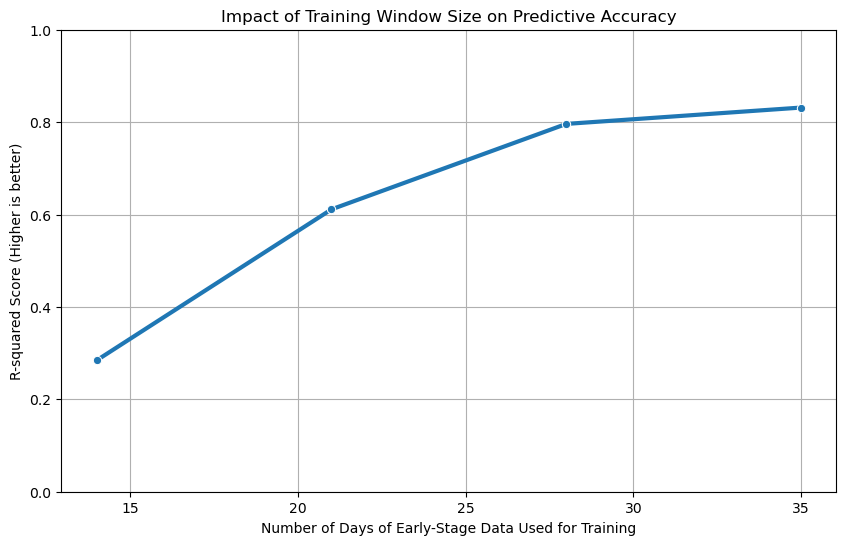


--- Summary of Results ---
 Days of Training Data  R-squared
                    14   0.284304
                    21   0.611193
                    28   0.796143
                    35   0.831525


In [23]:
from scipy.stats import linregress
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define a function to run the entire modeling pipeline ---
def run_prediction_for_threshold(day_threshold, merged_df):
    """
    Runs the full feature engineering and modeling pipeline for a given
    number of early days and returns the R-squared score.
    """
    print(f"--- Running analysis for first {day_threshold} days ---")
    
    # 1. Feature Engineering
    early_df = merged_df[merged_df['Days_Since_2024_05_26'] <= day_threshold]

    def calculate_all_slopes(group_df):
        slopes = {}
        time_col = 'Days_Since_2024_05_26'
        feature_cols_for_slope = ['area', 'height', 'green_red_mean']
        for col in feature_cols_for_slope:
            if len(group_df) < 2:
                slopes[f'{col}_slope'] = 0
            else:
                slope, _, _, _, _ = linregress(group_df[time_col], group_df[col])
                slopes[f'{col}_slope'] = slope
        return pd.Series(slopes)

    slope_features = early_df.groupby('Plant Info').apply(calculate_all_slopes)
    genotype_df = merged_df[['Plant Info', 'Plant.Genotype']].drop_duplicates().set_index('Plant Info')
    genotype_dummies = pd.get_dummies(genotype_df['Plant.Genotype'], prefix='geno')
    feature_df = slope_features.join(genotype_dummies)

    # 2. Target Definition
    last_day = merged_df['Date'].max()
    final_day_data = merged_df[merged_df['Date'] == last_day]
    target_df = final_day_data.groupby('Plant Info')[['area']].mean().rename(columns={'area': 'Final_Area'})
    modeling_df = pd.merge(feature_df, target_df, on='Plant Info', how='inner').dropna()

    # 3. Model Training
    X = modeling_df.drop(columns=['Final_Area'])
    y = modeling_df['Final_Area']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"  R-squared for {day_threshold} days: {r2:.3f}\n")
    return r2

# --- Step 2: Loop through different time windows and collect results ---
time_windows = [14, 21, 28, 35] # Test different thresholds
r_squared_results = []

for days in time_windows:
    score = run_prediction_for_threshold(days, merged_df)
    r_squared_results.append({'Days of Training Data': days, 'R-squared': score})

results_df = pd.DataFrame(r_squared_results)


# --- Step 3: Visualize the impact of more training data ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Days of Training Data', y='R-squared', marker='o', lw=3)
plt.title('Impact of Training Window Size on Predictive Accuracy')
plt.ylabel('R-squared Score (Higher is better)')
plt.xlabel('Number of Days of Early-Stage Data Used for Training')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("\n--- Summary of Results ---")
print(results_df.to_string(index=False))